In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import json
import cv2
import requests
import io
import math

from pprint import PrettyPrinter

import sys
sys.path.append('../')

import torch
import torchvision.transforms as T


import itertools
from panopticapi.utils import id2rgb, rgb2id
from PIL import Image

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

%load_ext autoreload
%autoreload 2
eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


In [2]:
use_cuda = True
if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    torch.cuda.set_device(1)
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")

GPU


In [7]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [3]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)


Using cache found in /home/rezaeifa/.cache/torch/hub/facebookresearch_detr_master


In [4]:
model.eval();

In [5]:
url = "http://images.cocodataset.org/val2017/000000281759.jpg"
im = Image.open(requests.get(url, stream=True).raw)

In [8]:
img = transform(im).unsqueeze(0)
out = model(img)


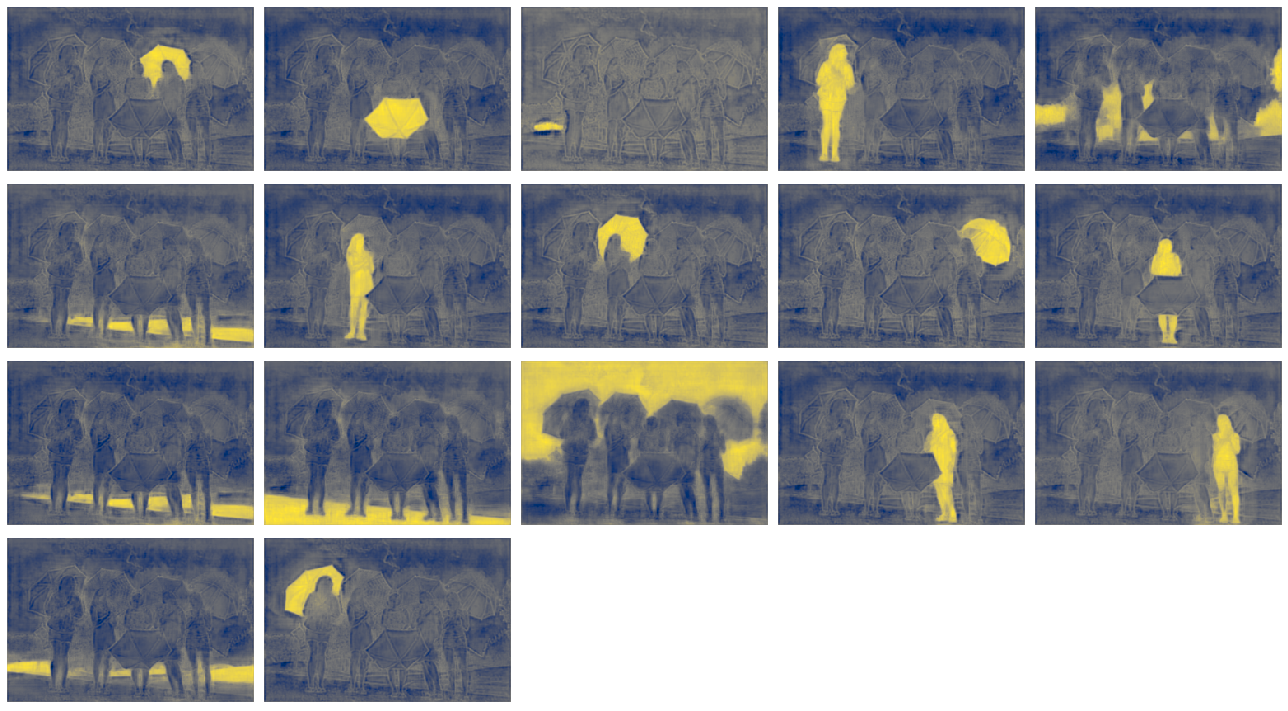

In [29]:
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask.detach(), cmap="cividis")
    ax.axis('off')
fig.tight_layout()

In [30]:
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [16]:
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

NameError: name 'result' is not defined